In [1]:
from sklearn.datasets import fetch_openml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Data Import

In [2]:
#Import MNIST dataset, and since it's image data, we prefer to get it as an array rather than as a dataframe
mnist = fetch_openml('mnist_784', as_frame=False) 
X, y = mnist.data, mnist.target

/home/archangel/Git/MLLearning/.venv/lib/python3.10/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


# Introduction

In [3]:
#Let's look at the data
print('Desc of MNIST:\n', mnist.DESCR, '\n\n')

print(X)
print('\nShape(X): ', X.shape, '\nMin(X)-Max(X): ', np.min(X), '-', np.max(X), '\n\n')

print(y,'\nShape(y): ', y.shape, '\nMin(y)-Max(y): ', np.min(y), '-', np.max(y), '\n\n')

Desc of MNIST:
 **Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in

## Exploratory Comments
X is an array of floats, each row contains 784 values (since each image is of size 28x28=784), each value ranging between 0 (completely white) and 255 (completely black), therefore a grey scale.

y is an array of integers, each representing the number that is written.

The first 60'000 rows are intended to be used as training set, whereas the last 10'000 are intended to be the test set, and the set has been appropriately shuffled for this use.

## Explo Plot

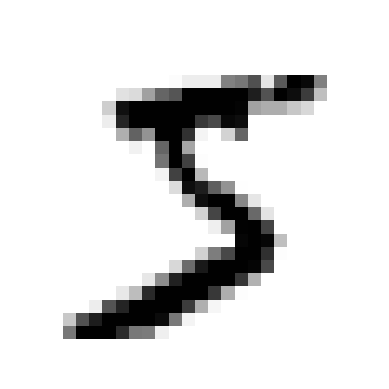

In [4]:
def plot_digit(image_data):
    image = image_data.reshape(28, 28) #All data of an image is stored on a single row, let's reshape so that it's a matrix
    plt.imshow(image, cmap="binary") #we specify binary so that we get a black/white image, rather than colorful
    plt.axis("off")

some_digit = X[0]
plot_digit(some_digit)
plt.show()

If I squint, I think it's supposed to be a 5...

In [5]:
print(y[0])

5


Alright, sounds good.

## Train-Test Split
Before fooling around more, let's define our train-test splits.
As mentioned previously, the first 60'000 rows are intended to be used as training set, whereas the last 10'000 are intended to be the test set, and the set has been appropriately shuffled for this use.

In [6]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Binary Classifier
Let's start simple, with a classifier to identify a single digit.
Based on recommendations of the book, we'll use a stochastic gradient descent classifier (SGDClassifier)

In [7]:
y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')

In [8]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [9]:
#Let's test our new binary classifier
sgd_clf.predict([some_digit])

array([ True])

Woohoo, it guessed correctly.
Well, checking each one individually might take a bit of time, so let's setup an automated system to handle that. I guess we should call that...

## Measuring Performances
And we'll make a first performance estimation based on the concept we saw in the previous chapter; cross-validation.
### Measuring Accuracy using Cross-Validation

In [10]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

/>95% accuracy on all three CV folds?

![suspicious_Fry_meme](https://i.kym-cdn.com/photos/images/newsfeed/000/131/399/fry.PNG?1307468855)


Honestly, I'm not sure I understood the point of the book following that, except that I do understand that I'd rather look at a confusion matrix rather than just the accuracy pcts. Right now, I might have correctly detected none of the 5 but also excluded all "not 5", leading to good accuracy. So let's print a confusion matrix.

#### Confusion Matrix

In [11]:
from sklearn.metrics import confusion_matrix
#Before we can create a CM, we need to predict on more than one value (I'm excluding the cross_val_score for now)
y_train_predict = sgd_clf.predict(X_train)
cm_5 = confusion_matrix(y_train_5, y_train_predict)
cm_5

array([[52316,  2263],
       [  601,  4820]])

Aww, come on, I was hoping the CM would be a bit more complete and graphic, like the ones in Matlab.
Let's "fix" this.

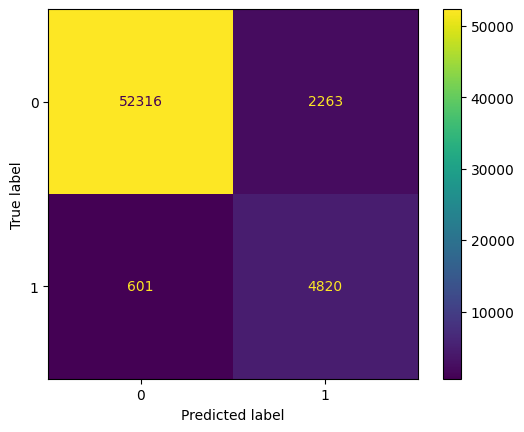

In [12]:
# Plotting a Confusion Matrix with Sklearn
from sklearn.metrics import ConfusionMatrixDisplay

vis = ConfusionMatrixDisplay(confusion_matrix=cm_5)
vis.plot()
plt.show()

<Axes: >

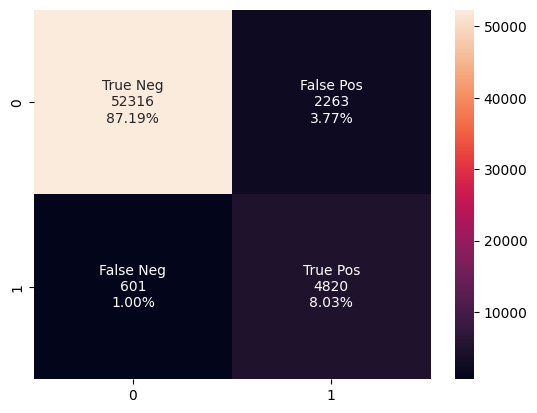

In [14]:
# Bleh, I still don't like it, I want to see both the numbers AND the pcts. 
# Let's do it ourselves (and define a function for it)

# Might as well as TP, TN, etc. labels
group_names = ["True Neg", "False Pos", "False Neg", "True Pos"]
# Compute the percentages
group_pcts = ["{0:.2%}".format(val) for val in cm_5.flatten()/np.sum(cm_5)]
# Create the final array of labels
labels = [f"{name}\n{val}\n{pct}" for name, val, pct in zip(group_names, cm_5.flatten(), group_pcts)]

import seaborn as sns
sns.heatmap(cm_5, annot=np.asarray(labels).reshape(2, 2), fmt='')

In [47]:
cm5_df = pd.DataFrame(cm_5, columns=['Predicted Negative', 'Predicted Positive'], index=['Actual Negative', 'Actual Positive'])
cm5_df['Total'] = cm5_df.sum(axis=1)
cm5_df.loc['Total'] = cm5_df.sum()

cm5_df

,Predicted Negative,Predicted Positive,Total
Actual Negative,52316,2263,54579
Actual Positive,601,4820,5421
Total,52917,7083,60000


<Axes: >

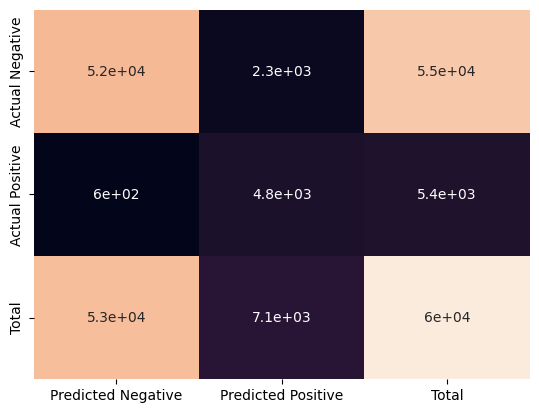

In [122]:
sns.heatmap(cm5_df, annot=True, cbar=False)

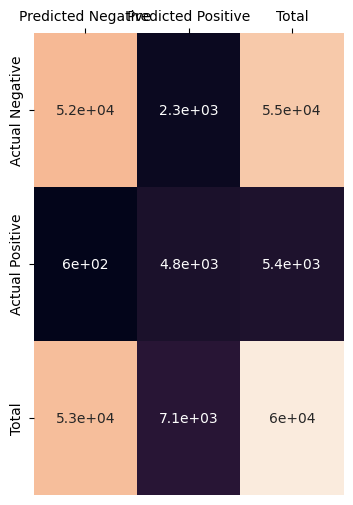

In [144]:
# from matplotlib.collections import QuadMesh
# from matplotlib.text import Text

# fig, ax = plt.subplots(1, 1, figsize =(4,6))

# sns.heatmap(cm5_df, annot=True, linewidths=0, cbar=False)

# # find your QuadMesh object and get array of colors
# quadmesh = ax.findobj(QuadMesh)[0]
# facecolors = quadmesh.get_facecolors()

# # make colors of the last column white
# facecolors[np.arange(2,9,3)] = np.array([1,1,1,1])

# # set modified colors
# quadmesh.set_facecolors = facecolors
# ax.findobj(QuadMesh)[0].set_facecolors = np.array([1,1,1,1])

# # move x ticks and label to the top
# ax.xaxis.tick_top()
# ax.xaxis.set_label_position('top') 

# plt.show()

<Axes: >

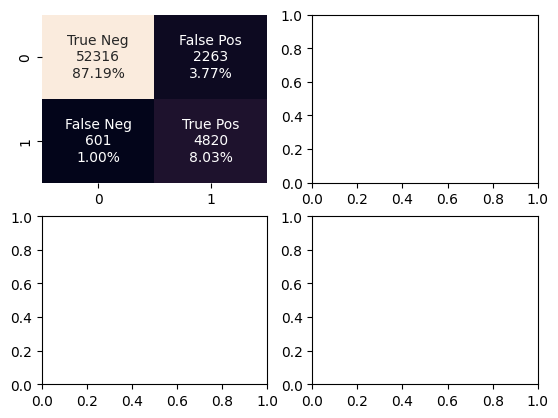

In [145]:
fig, axs = plt.subplots(2, 2)
sns.heatmap(cm_5, annot=np.asarray(labels).reshape(2, 2), fmt='', cbar=False, ax=axs[0, 0])

# Change the size of subplot 0 0 so that's it's much bigger, remove all 1 1 and "print" the total in 0 1 and 1 0, maybe we can share axes?

In [136]:
axs[0, 0]

<Axes: >